In [28]:
import pandas as pd
from pickle import load
from numpy import array
import numpy as np
import pydot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import random
import datetime

def trim_data(data):
     return data[:(len(data)-(len(data)%batch_size))]   

pref = 'traintest/100_' 
X_train = np.load(pref+'x_train.npy')
#X_val = np.load(pref+'x_val.npy') # won't be used here
y_train = np.load(pref+'y_train.npy')
#y_val = np.load(pref+'y_val.npy') # won't be used here
X_test = np.load(pref+'x_test.npy')
y_test = np.load(pref+'y_test.npy')

time_step = 100
batch_size = len(X_train)
#batch_size = 1

#X_train = trim_data(X_train)
#X_val = trim_data(X_val) # won't be used here
#y_train = np.load(y_train)
#y_val = trim_data(np.load(pref+'y_val.npy')) # won't be used here



<h1> 1 - Training the LSTM </h1>

* we define a stacked model with several LSTM layers, several dense layers, and one output with 2 neurons

In [92]:
# training
lstm_model = Sequential()
lstm_model.add(LSTM(32, batch_input_shape=(len(X_train), time_step, X_train.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=True))
lstm_model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=True))
lstm_model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(32,activation='tanh'))
#lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(16,activation='tanh'))
#lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(8,activation='tanh'))
lstm_model.add(Dense(y_train.shape[1],activation='sigmoid'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['acc'])


* since we want out LSTM layers to be stateful within our Epoch but NOT between Epochs, we manually force the Epoch cycle and include a reset_state at the end:

In [ ]:
csv_logger = CSVLogger(('logex' + '.log'), append=True)

n_epoch = 10
for i in range(n_epoch):
    lstm_model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    lstm_model.reset_states()
    #if i%10 == 0:
    print("done {} cycles".format(i), datetime.datetime.now())

old_weights = lstm_model.get_weights()

#lstm_model.save_weights('stacked_LSTM_weights.h5')


<h1> 2 - test the model </h1>
* the testing will be done wiht a batchsize of 1 (we don't produce a time series but a classification). Problem here is that batchsize will diverge from training, and Keras will not allow that. We must redefine a new model similar to training (except for batchsize) and load weights obtained from training into it.
* then, prediction is executed through a loop

In [40]:
#predicting
new_model = Sequential()
new_model.add(LSTM(32, batch_input_shape=(1, time_step, X_train.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=True))
new_model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=True))
new_model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
new_model.add(Dropout(0.5))
new_model.add(Dense(32,activation='tanh'))
#new_model.add(Dropout(0.5))
new_model.add(Dense(16,activation='tanh'))
#lstm_model.add(Dropout(0.5))
new_model.add(Dense(8,activation='tanh'))
new_model.add(Dense(y_train.shape[1],activation='sigmoid'))
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['acc'])

In [ ]:
new_model.load_weights('stacked_LSTM_weights_backup.h5')
#new_model.set_weights(old_weights)

pred1 = []
pred2 = []
for i in range(len(X_test) - 1):
    X_test_solo= X_test[i]
    X_test_solo = X_test_solo.reshape(1,time_step, X_test.shape[2])
    res = new_model.predict(X_test_solo, batch_size = 1, verbose=0, steps= None)
    pred1.append(float(res[0][0]))
    pred2.append(float(res[0][1]))
    if i%1000:
        print(i)
    

<h1> 3 - combine results </h1>


In [33]:
# analysing
pred = pd.DataFrame()
pred["result_buy"] = pred1
pred["result_sell"] = pred2
pred["true_buy"] = pd.DataFrame(y_test)[0]
pred["true_sell"] = pd.DataFrame(y_test)[1]
pred.sort_values("result_buy", ascending = False)
pred.to_csv(pref+'test_pred.csv')

confusion matrix on buy: 
[[    7    10]
 [ 2146 25136]]
confusion matrix on sell: 
[[    4     5]
 [ 1838 25452]]


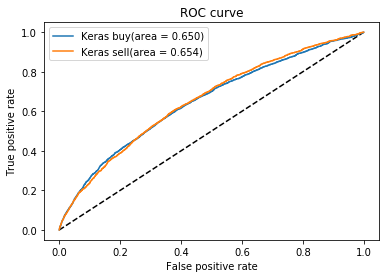

In [162]:
# define the level of confidence we want to declare our prediction a high or a low
pred = pd.read_csv("traintest/100_100_test_pred.csv", index_col=0)

thresh_buy = .781
thresh_sell = .96

# enrich our prediction with Buy/sell as 1 or 0
pred["buy?"] = pred["result_buy"].apply(lambda x: 1 if x > thresh_buy else 0)
pred["sell?"] = pred["result_sell"].apply(lambda x: 1 if x > thresh_sell else 0)

# produce a confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print("confusion matrix on buy: \n{}".format(confusion_matrix(pred["buy?"], pred["true_buy"], labels=[1,0])))
print("confusion matrix on sell: \n{}".format(confusion_matrix(pred["sell?"],pred["true_sell"],  labels=[1,0])))

# produce a ROC curve
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(pred["true_buy"], pred["result_buy"])
fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(pred["true_sell"], pred["result_sell"])
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras2 = auc(fpr_keras2, tpr_keras2)
from matplotlib import pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras buy(area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras2, tpr_keras2, label='Keras sell(area = {:.3f})'.format(auc_keras2))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

pred.to_csv("traintest/100_100_test_pred.csv")

<h1> 4 - Measure profit with my estimate </h1>

* loop through our test set. 
* Whenever I predicted a "Buy", consider I buy
* On next predicted "sell", consider I seel, and capture profit

In [161]:
pred.sort_values('result_sell', ascending=False)


,result_buy,result_sell,true_buy,true_sell,buy?,sell?
25026,0.195398,0.961670,0,1,0,1
8073,0.195984,0.960763,0,0,0,1
1543,0.196200,0.960441,0,0,0,1
7278,0.196263,0.960350,0,1,0,1
3091,0.196316,0.960275,0,0,0,1
1242,0.196387,0.960159,0,0,0,1
25010,0.196441,0.960084,0,0,0,1
7157,0.196469,0.960048,0,1,0,1
26668,0.196490,0.960031,0,1,0,1
1281,0.196867,0.959490,0,1,0,0


In [163]:
test = pd.read_csv("traintest/test_data_backup.csv", index_col=None).reindex()

liste1 = list(pred.true_buy)
liste2 = list(test.is_l100)
liste3 = list(pred["buy?"])
liste1.extend([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
liste3.extend([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
liste1 = pd.Series(liste1)
liste2 = pd.Series(liste2)
liste3 = pd.Series(liste3)
TF = liste1 == liste2
test["buy?"] = liste3
test["true1"] = TF

liste1 = list(pred.true_sell)
liste2 = list(test.is_h100)
liste3 = list(pred["sell?"])

liste1.extend([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
liste3.extend([0,0,0,0,0,0,0,0,0,0,0,0,0,0])

liste1 = pd.Series(liste1)
liste2 = pd.Series(liste2)
liste3 = pd.Series(liste3)

TF = liste1 == liste2
test["sell?"] = liste3
test["true2"] = TF

test = test[(test["true1"]==True) & (test["true2"]==True) ]

In [165]:
check_steps = [1,100,1000,10000,30000]

look_for = 'buy'
buy_price = .0
for i in test.index:
    if look_for == 'buy' and test.loc[i,"buy?"]==1:
        buy_price = test.loc[i,"low"]
        buy_time = i
        look_for = "sell"
    elif look_for == 'sell' and test.loc[i,"sell?"]==1:
        test.loc[i,"profit"] = 0.99*test.loc[i,"high"] - buy_price # a penalty of 1% is applied to represent trade fees applied by excahnge  platform
        test.loc[i,"immo_time"] = i - buy_time
        look_for = "buy"
    if i in check_steps:
        print("over {}".format(i),datetime.datetime.now())     

over 1 2019-05-16 17:23:23.965700
over 100 2019-05-16 17:23:23.967866
over 1000 2019-05-16 17:23:23.980687
over 10000 2019-05-16 17:23:24.214728


In [188]:
pd.options.display.max_rows = 999

print("profit achieved:", round(test["profit"].sum() / test.open[27312] *100,2),"%", "average investment time:", test["immo_time"].mean()/60/24,"days")
print("vs. organic market growth =>", round((test.open[27312] - test.open[0]) / test.open[0] *100,2),"%")


profit achieved: 12.79 % average investment time: 2.2250992063492068 days
vs. organic market growth => 7.53 %


In [189]:
test.sort_values("profit", ascending=False)

,Unnamed: 0,close,closeTime,high,low,numTrades,open,openTime,quoteVolume,volume,...,overall_gap,where_in_gap,history,buyer_is_maker,buy?,true1,sell?,true2,profit,immo_time
25010,185450,5437.75,2019-04-23 06:10:59.999,5477.77,5437.72,0.222241,5475.11,2019-04-23 06:10:00,1.494258e+06,273.785017,...,40.05,-19.995,[[0.67867005 0.00937866 0.57508759]\n [0.67509...,0.496407,0,True,1,True,496.5623,16003.0
7157,167597,5369.27,2019-04-10 20:37:59.999,5404.79,5367.03,0.208005,5400.91,2019-04-10 20:37:00,1.287315e+06,238.997537,...,37.76,-16.640,[[0.66999155 0.01457042 0.58522591]\n [0.67193...,0.459480,0,True,1,True,230.7421,4065.0
3091,163531,5135.77,2019-04-08 00:51:59.999,5190.17,5130.01,0.254396,5190.17,2019-04-08 00:51:00,1.141631e+06,220.968313,...,60.16,-24.320,[[0.67847281 0.00988109 0.79065347]\n [0.67309...,0.522520,0,True,1,True,186.1683,1541.0
25026,185466,5538.69,2019-04-23 06:26:59.999,5600.00,5536.21,0.447161,5592.15,2019-04-23 06:26:00,4.251759e+06,762.335670,...,63.79,-29.415,[[0.69459003 0.02227433 0.56595922]\n [0.69935...,0.474308,0,True,1,True,79.8100,3.0
7278,167718,5254.55,2019-04-10 22:38:59.999,5321.42,5227.84,0.575950,5321.05,2019-04-10 22:38:00,3.978824e+06,754.084183,...,93.58,-20.080,[[0.67128769 0.05308993 0.36520387]\n [0.69577...,0.539644,0,True,1,True,-49.1742,6.0
1543,161983,4987.50,2019-04-06 23:03:59.999,5046.39,4975.00,0.559705,5044.42,2019-04-06 23:03:00,2.679719e+06,536.327265,...,71.39,-23.195,[[0.67999436 0.04957294 0.3641076 ]\n [0.68827...,0.463260,0,True,1,True,-91.0739,19.0
8073,168513,5014.00,2019-04-11 11:53:59.999,5073.73,5011.37,0.528387,5073.73,2019-04-11 11:53:00,2.956279e+06,586.364305,...,62.36,-28.550,[[0.631051 0.09562887 0.54490027]\n [0.67988...,0.490335,0,True,1,True,-167.1173,792.0
0,160440,4983.85,2019-04-05 21:20:59.999,4987.88,4982.71,0.021269,4986.15,2019-04-05 21:20:00,5.067373e+04,10.164529,...,5.17,-1.445,[[0.66706114 0.03617485 0.60923845]\n [0.69768...,0.586540,0,True,0,True,NaN,NaN
1,160441,4983.82,2019-04-05 21:21:59.999,4985.32,4982.80,0.012728,4984.05,2019-04-05 21:21:00,3.171265e+04,6.362820,...,2.52,-0.240,[[0.69768949 0.01959471 0.479896 ]\n [0.69092...,0.527774,0,True,0,True,NaN,NaN
2,160442,4984.80,2019-04-05 21:22:59.999,4985.29,4982.75,0.012393,4982.82,2019-04-05 21:22:00,4.302171e+04,8.632651,...,2.54,0.780,[[0.69092702 0.03952437 0.5342655 ]\n [0.66396...,0.483242,0,True,0,True,NaN,NaN


In [194]:
test[["close","is_l100","is_h100","buy?","sell?","profit"]].to_csv('analysis_profit.csv')

In [169]:
685 / 5354

0.12794172581247665

In [190]:
16000 / 60 / 24

11.111111111111112